In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import json
import time

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Reload features to ensure we have the latest logic
import src.features
import importlib
importlib.reload(src.features)
from src.features import extract_user_attributes, aggregate_user_features

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load Raw Data & Raw Comparison
We load both Train and Test raw data to compare their fundamental characteristics before any feature engineering.

Loading Raw Data...
Train Raw Shape: (17499636, 19)
Test Raw Shape: (4393179, 19)
Train Raw Shape: (17499636, 19)
Test Raw Shape: (4393179, 19)

--- RAW DATA COMPARISON ---
Train Time Range: 2018-10-01 00:00:01 to 2018-11-20 00:00:00
Test Time Range: 2018-10-01 00:00:06 to 2018-11-20 00:00:00
Train Duration: 49 days
Test Duration: 49 days

--- RAW DATA COMPARISON ---
Train Time Range: 2018-10-01 00:00:01 to 2018-11-20 00:00:00
Test Time Range: 2018-10-01 00:00:06 to 2018-11-20 00:00:00
Train Duration: 49 days
Test Duration: 49 days

Events per User (Train):
count    19140.000000
mean       914.296552
std       1079.652218
min          1.000000
25%        202.000000
50%        537.500000
75%       1213.000000
max      10998.000000
dtype: float64

Events per User (Test):
count      2904.000000
mean       1512.802686
std       12179.711145
min           1.000000
25%         368.000000
50%         835.500000
75%        1781.000000
max      653681.000000
dtype: float64

Events per User (Tra

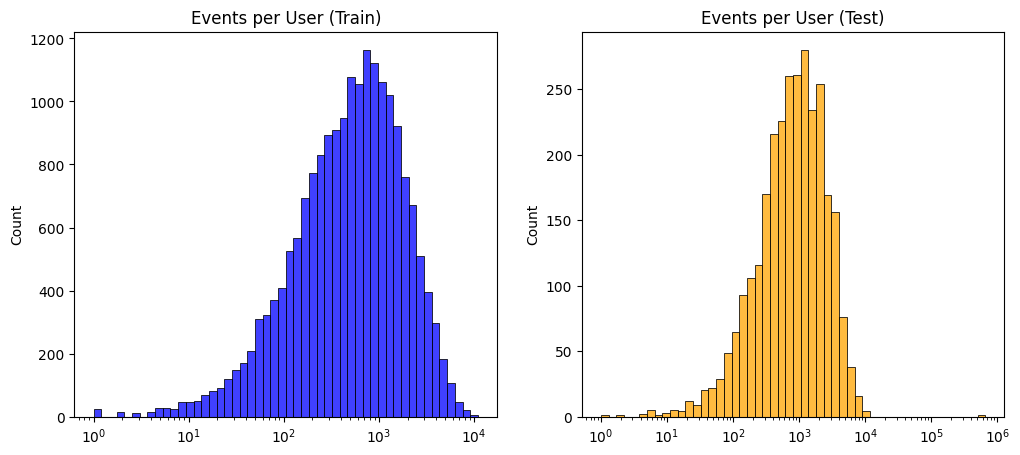


Page Distribution Difference (Train - Test):
                    Train      Test      Diff
page                                         
NextSong         0.816670  0.696947  0.119724
Home             0.036873  0.109674 -0.072801
About            0.001892  0.010126 -0.008234
Thumbs Up        0.045109  0.038093  0.007016
Help             0.005088  0.009253 -0.004165
Add to Playlist  0.023407  0.019905  0.003501
Roll Advert      0.016277  0.012916  0.003361
Add Friend       0.014980  0.012845  0.002135
Logout           0.011697  0.009946  0.001751
Thumbs Down      0.009427  0.008050  0.001376


In [2]:
print("Loading Raw Data...")
train_df_raw = pd.read_parquet('../data/train.parquet')
test_df_raw = pd.read_parquet('../data/test.parquet')

print(f"Train Raw Shape: {train_df_raw.shape}")
print(f"Test Raw Shape: {test_df_raw.shape}")

# Apply basic extraction for timestamps
train_df_raw = extract_user_attributes(train_df_raw)
test_df_raw = extract_user_attributes(test_df_raw)

# --- RAW DATA COMPARISON ---
print("\n--- RAW DATA COMPARISON ---")

# 1. Time Range
print(f"Train Time Range: {train_df_raw['ts'].min()} to {train_df_raw['ts'].max()}")
print(f"Test Time Range: {test_df_raw['ts'].min()} to {test_df_raw['ts'].max()}")
train_duration = (train_df_raw['ts'].max() - train_df_raw['ts'].min()).days
test_duration = (test_df_raw['ts'].max() - test_df_raw['ts'].min()).days
print(f"Train Duration: {train_duration} days")
print(f"Test Duration: {test_duration} days")

# 2. Events per User
train_events_per_user = train_df_raw.groupby('userId').size()
test_events_per_user = test_df_raw.groupby('userId').size()

print("\nEvents per User (Train):")
print(train_events_per_user.describe())
print("\nEvents per User (Test):")
print(test_events_per_user.describe())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_events_per_user, bins=50, log_scale=True, color='blue', label='Train')  # type: ignore
plt.title('Events per User (Train)')
plt.subplot(1, 2, 2)
sns.histplot(test_events_per_user, bins=50, log_scale=True, color='orange', label='Test')  # type: ignore
plt.title('Events per User (Test)')
plt.show()

# 3. Page Distribution (Activity Type)
train_page_dist = train_df_raw['page'].value_counts(normalize=True)
test_page_dist = test_df_raw['page'].value_counts(normalize=True)

comparison_df = pd.DataFrame({'Train': train_page_dist, 'Test': test_page_dist})
comparison_df['Diff'] = comparison_df['Train'] - comparison_df['Test']
print("\nPage Distribution Difference (Train - Test):")
print(comparison_df.sort_values(by='Diff', key=abs, ascending=False).head(10))

## 2. Single Snapshot Strategy (Temporal Holdout)
To mimic the Test Set (where we predict the future based on a snapshot), we create a **Strict Temporal Cutoff** in our Training Data.

In [3]:
# Define the Cutoff
# We assume the test set covers roughly the last 2 weeks (based on typical churn windows).
# We hide the last 14 days of the training set to use as our "Ground Truth" future.

GLOBAL_MAX_TS = train_df_raw['ts'].max()
PREDICTION_WINDOW_DAYS = 14
CUTOFF_TS = GLOBAL_MAX_TS - pd.Timedelta(days=PREDICTION_WINDOW_DAYS)

print(f"Global Max Timestamp: {GLOBAL_MAX_TS}")
print(f"Training Cutoff Timestamp: {CUTOFF_TS}")

# Identify Active Users BEFORE Cutoff
active_users_pre_cutoff = train_df_raw[train_df_raw['ts'] <= CUTOFF_TS]['userId'].unique()

# Create Snapshot DataFrame
snapshot_df = pd.DataFrame({
    'userId': active_users_pre_cutoff,
    'cutoff_ts': CUTOFF_TS
})

print("Aggregating features relative to Cutoff (Train Snapshot)...")
X_snapshot = aggregate_user_features(train_df_raw, snapshot_df=snapshot_df)
X_snapshot = X_snapshot.reset_index(level='cutoff_ts', drop=True)

# Generate Targets (Look ahead)
print("Generating Targets...")
future_events = train_df_raw[train_df_raw['ts'] > CUTOFF_TS]
churners = future_events[future_events['page'] == 'Cancellation Confirmation']['userId'].unique()

X_snapshot['target'] = 0
X_snapshot.loc[X_snapshot.index.isin(churners), 'target'] = 1

print(f"Snapshot Shape: {X_snapshot.shape}")
print(f"Churn Rate: {X_snapshot['target'].mean():.2%}")

Global Max Timestamp: 2018-11-20 00:00:00
Training Cutoff Timestamp: 2018-11-06 00:00:00
Aggregating features relative to Cutoff (Train Snapshot)...
Aggregating features relative to Cutoff (Train Snapshot)...
Generating Targets...
Generating Targets...
Snapshot Shape: (18670, 65)
Churn Rate: 5.36%
Snapshot Shape: (18670, 65)
Churn Rate: 5.36%


## 3. Generate Test Features (for Comparison)
We generate features for the actual Test Set using its end date as the cutoff.

In [4]:
test_max_ts = test_df_raw['ts'].max()
test_snapshot_df = pd.DataFrame({
    'userId': test_df_raw['userId'].unique(),
    'cutoff_ts': test_max_ts
})

print("Aggregating features for Test Set...")
X_test_features = aggregate_user_features(test_df_raw, snapshot_df=test_snapshot_df)
X_test_features = X_test_features.reset_index(level='cutoff_ts', drop=True)

# Align columns
common_cols = [c for c in X_snapshot.columns if c in X_test_features.columns and c != 'target']
X_snapshot_aligned = X_snapshot[common_cols]
X_test_aligned = X_test_features[common_cols]

print(f"Aligned Feature Count: {len(common_cols)}")

Aggregating features for Test Set...
Aligned Feature Count: 64
Aligned Feature Count: 64


## 4. Featured Data Comparison (Train vs Test)
We check if the feature distributions match. Large divergences indicate "Covariate Shift".

Top Feature Divergences (by Mean % Diff):
                    mean_train      std_train      mean_test       std_test  \
total_sessions        8.521639       8.319452      61.310606    2494.487275   
activity_trend       -0.637753      17.219256       1.287405      20.213491   
errors_per_song       0.001293       0.003934       0.002988       0.092809   
is_error              0.685592       1.158138       1.530647      14.312819   
length           140808.756880  173213.548326  262268.563798  276402.835346   
is_song             566.135083     696.321028    1054.342631    1111.181129   
is_thumbs_up         31.169202      40.400061      57.627755      65.501590   
errors_last_3d        0.041725       0.226350       0.077135       0.739310   
is_thumbs_down        6.604017       8.288434      12.178719      13.434192   
errors_last_1d        0.017943       0.140587       0.032713       0.423188   

                 mean_diff_pct  std_diff_pct  
total_sessions       -6.194696   -298.837

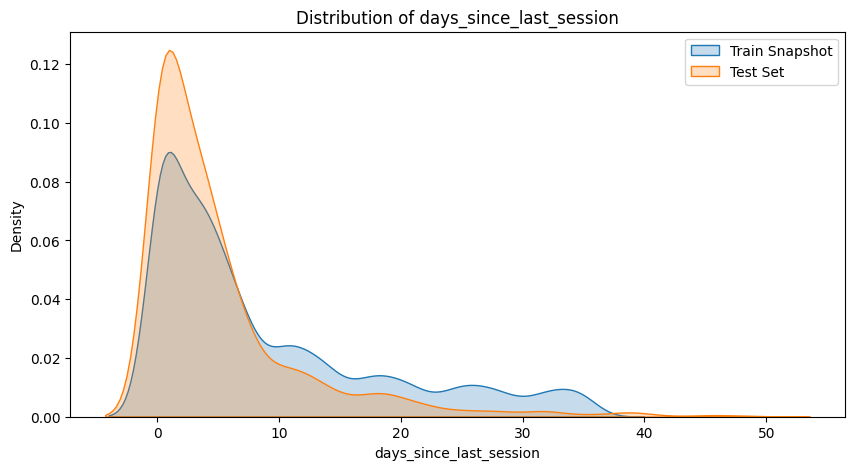

In [5]:
# Compare Mean and Std of key features
train_stats = X_snapshot_aligned.describe().T[['mean', 'std']]
test_stats = X_test_aligned.describe().T[['mean', 'std']]

stats_comparison = train_stats.join(test_stats, lsuffix='_train', rsuffix='_test')
stats_comparison['mean_diff_pct'] = (stats_comparison['mean_train'] - stats_comparison['mean_test']) / (stats_comparison['mean_train'] + 1e-9)
stats_comparison['std_diff_pct'] = (stats_comparison['std_train'] - stats_comparison['std_test']) / (stats_comparison['std_train'] + 1e-9)

print("Top Feature Divergences (by Mean % Diff):")
print(stats_comparison.sort_values(by='mean_diff_pct', key=abs, ascending=False).head(10))

# Plot distribution of a key feature (e.g., days_since_last_session)
feature_to_plot = 'days_since_last_session'
if feature_to_plot in X_snapshot_aligned.columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(X_snapshot_aligned[feature_to_plot], label='Train Snapshot', fill=True)
    sns.kdeplot(X_test_aligned[feature_to_plot], label='Test Set', fill=True)
    plt.title(f"Distribution of {feature_to_plot}")
    plt.legend()
    plt.show()

## 5. Train & Evaluate (Sanity Check)
We train a simple XGBoost on the Snapshot data to see if it learns real signal or leakage.

Training on 14936 samples, Validating on 3734 samples

--- Validation Results ---
ROC-AUC: 0.7109
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3534
           1       0.20      0.02      0.04       200

    accuracy                           0.94      3734
   macro avg       0.57      0.51      0.50      3734
weighted avg       0.91      0.94      0.92      3734


--- Validation Results ---
ROC-AUC: 0.7109
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3534
           1       0.20      0.02      0.04       200

    accuracy                           0.94      3734
   macro avg       0.57      0.51      0.50      3734
weighted avg       0.91      0.94      0.92      3734



/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:57:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x800 with 0 Axes>

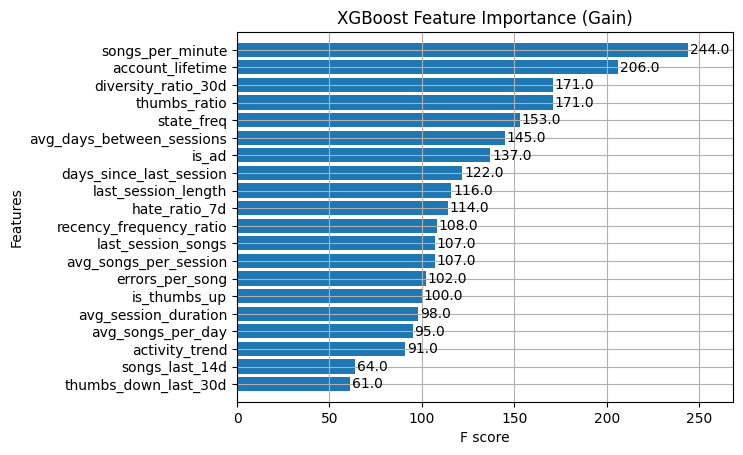

In [6]:
# Split Snapshot into Train/Val
X_train, X_val, y_train, y_val = train_test_split(
    X_snapshot.drop(columns=['target']), X_snapshot['target'], 
    test_size=0.2, random_state=RANDOM_SEED, stratify=X_snapshot['target']
)

# Select numeric only
X_train = X_train.select_dtypes(include=[np.number])
X_val = X_val.select_dtypes(include=[np.number])

print(f"Training on {X_train.shape[0]} samples, Validating on {X_val.shape[0]} samples")

model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_SEED)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
y_probs = model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_probs)
print("\n--- Validation Results ---")
print(f"ROC-AUC: {roc_auc:.4f}")
print(classification_report(y_val, y_pred))

# Feature Importance
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=20, height=0.8)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [7]:
print("--- AUTOMATED REPORT FOR AI AGENT ---")
print(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}")

report = {
    "raw_data": {
        "train_duration_days": train_duration,
        "test_duration_days": test_duration,
        "train_events_per_user_mean": train_events_per_user.mean(),
        "test_events_per_user_mean": test_events_per_user.mean(),
    },
    "feature_divergence": stats_comparison.sort_values(by='mean_diff_pct', key=abs, ascending=False).head(5).to_dict(orient='index'),
    "model_performance": {
        "roc_auc": roc_auc,
        "classification_report": classification_report(y_val, y_pred, output_dict=True)
    },
    "top_features": list(pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values(ascending=False).head(5).index)
}

print(json.dumps(report, indent=2, default=str))
print("-------------------------------------")

--- AUTOMATED REPORT FOR AI AGENT ---
Date: 2025-12-05 03:57:02
{
  "raw_data": {
    "train_duration_days": 49,
    "test_duration_days": 49,
    "train_events_per_user_mean": 914.2965517241379,
    "test_events_per_user_mean": 1512.8026859504132
  },
  "feature_divergence": {
    "total_sessions": {
      "mean_train": 8.521638993036957,
      "std_train": 8.319452012954626,
      "mean_test": 61.31060606060606,
      "std_test": 2494.48727518234,
      "mean_diff_pct": -6.194696478518786,
      "std_diff_pct": -298.83793055110044
    },
    "activity_trend": {
      "mean_train": -0.6377529522789297,
      "std_train": 17.21925550178844,
      "mean_test": 1.2874048930867112,
      "std_test": 20.213491235431697,
      "mean_diff_pct": 3.018657681638305,
      "std_diff_pct": -0.17388880333173404
    },
    "errors_per_song": {
      "mean_train": 0.001292527916478829,
      "std_train": 0.003934357227106103,
      "mean_test": 0.0029879539725874205,
      "std_test": 0.092808936892

In [8]:
# --- LOAD PREVIOUS MODEL (Exp 13 - 0.63630) ---
import joblib

print("\n--- LOADING EXP 13 MODEL ---")
try:
    # Load the Stacking/Voting Model
    model_path = "../models/stacking_model.joblib"
    loaded_model = joblib.load(model_path)
    print(f"Loaded model from {model_path}")
    
    # Load Feature Names
    features_path = "../models/feature_names.joblib"
    feature_names = joblib.load(features_path)
    print(f"Loaded {len(feature_names)} feature names.")
    
    # Check if our current snapshot has these features
    missing_features = set(feature_names) - set(X_snapshot.columns)
    if missing_features:
        print(f"⚠️ Warning: {len(missing_features)} features missing in Sanity Check snapshot:")
        print(list(missing_features)[:5])
        # Fill missing with 0 for analysis
        for f in missing_features:
            X_snapshot[f] = 0
            X_test_features[f] = 0
            
    # Align columns
    X_snapshot_aligned_model = X_snapshot[feature_names]
    X_test_aligned_model = X_test_features[feature_names]
    
    # --- FEATURE DIVERGENCE ANALYSIS (MODEL FEATURES ONLY) ---
    print("\n--- DIVERGENCE ANALYSIS (EXP 13 FEATURES) ---")
    train_stats_m = X_snapshot_aligned_model.describe().T[['mean', 'std']]
    test_stats_m = X_test_aligned_model.describe().T[['mean', 'std']]

    stats_comp_m = train_stats_m.join(test_stats_m, lsuffix='_train', rsuffix='_test')
    stats_comp_m['mean_diff_pct'] = (stats_comp_m['mean_train'] - stats_comp_m['mean_test']) / (stats_comp_m['mean_train'] + 1e-9)
    
    print("Top Divergences in Model Features:")
    print(stats_comp_m.sort_values(by='mean_diff_pct', key=abs, ascending=False).head(10))
    
    # --- PREDICT WITH LOADED MODEL ---
    # We need to preprocess first!
    preprocessor_path = "../models/preprocessor.joblib"
    loaded_preprocessor = joblib.load(preprocessor_path)
    print(f"Loaded preprocessor from {preprocessor_path}")
    
    # Transform
    # Note: Preprocessor expects specific columns. We ensure X_snapshot has them.
    # We might need to be careful if preprocessor was fitted on different columns.
    # Assuming feature_names matches preprocessor expectations.
    
    try:
        # We use the raw snapshot (before alignment) but ensure it has all cols
        # Actually, the pipeline usually includes the preprocessor.
        # Let's check if the loaded model is a Pipeline or VotingClassifier
        
        if hasattr(loaded_model, 'estimators'):
            print("Model is a Voting/Stacking Classifier.")
            # The estimators inside likely have their own pipelines?
            # Or is it Pipeline(preprocessor, Voting)?
            # In Modeling.ipynb, it was VotingClassifier(estimators=[('xgb', Pipeline...), ...])
            # So the VotingClassifier expects RAW features (pandas df).
            
            print("Predicting with loaded model on Sanity Snapshot...")
            y_pred_loaded = loaded_model.predict(X_snapshot_aligned_model)
            y_probs_loaded = loaded_model.predict_proba(X_snapshot_aligned_model)[:, 1]
            
            print(f"Loaded Model ROC-AUC on Sanity Snapshot: {roc_auc_score(X_snapshot['target'], y_probs_loaded):.4f}")
            print(classification_report(X_snapshot['target'], y_pred_loaded))
            
    except Exception as e:
        print(f"Prediction failed: {e}")

except FileNotFoundError:
    print("❌ Model files not found. Did you run Modeling.ipynb to save them?")


--- LOADING EXP 13 MODEL ---
Loaded model from ../models/stacking_model.joblib
Loaded 64 feature names.

--- DIVERGENCE ANALYSIS (EXP 13 FEATURES) ---
Top Divergences in Model Features:
                    mean_train      std_train      mean_test       std_test  \
total_sessions        8.521639       8.319452      61.310606    2494.487275   
activity_trend       -0.637753      17.219256       1.287405      20.213491   
errors_per_song       0.001293       0.003934       0.002988       0.092809   
is_error              0.685592       1.158138       1.530647      14.312819   
length           140808.756880  173213.548326  262268.563798  276402.835346   
is_song             566.135083     696.321028    1054.342631    1111.181129   
is_thumbs_up         31.169202      40.400061      57.627755      65.501590   
errors_last_3d        0.041725       0.226350       0.077135       0.739310   
is_thumbs_down        6.604017       8.288434      12.178719      13.434192   
errors_last_1d        0

/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/users/eleves-b/2025/romain.etienne/Projects/Python4DataScience/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Loaded Model ROC-AUC on Sanity Snapshot: 0.8473
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     17670
           1       0.30      0.44      0.36      1000

    accuracy                           0.92     18670
   macro avg       0.64      0.69      0.66     18670
weighted avg       0.93      0.92      0.92     18670

